In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [3]:
#Assign column names to my data because it doesn't have any

column_names = ['Year', 'Month', 'Day', 'Index1', 'Index2', 'Phase', 'Amplitude']

# Read the MJO.txt file
mjo_data = pd.read_csv("/home/jstancz/data/MJO.txt", sep='\s+', header=None, names=column_names)

# Display the first few rows
print(mjo_data)

      Year  Month  Day   Index1   Index2  Phase  Amplitude
0     2011      1    1  0.31961  0.17840      3   0.366029
1     2011      1    2  0.25930  0.17280      3   0.311603
2     2011      1    3  0.19034  0.18693      3   0.266781
3     2011      1    4  0.11360  0.22080      4   0.248309
4     2011      1    5  0.03045  0.27281      4   0.274504
...    ...    ...  ...      ...      ...    ...        ...
2643  2018      3   28 -1.38235  0.82949      6   1.612124
2644  2018      3   29 -1.41948  0.78580      6   1.622469
2645  2018      3   30 -1.43539  0.70210      6   1.597902
2646  2018      3   31 -1.42788  0.57662      6   1.539913
2647  2018      4    1 -1.39443  0.41067      6   1.453645

[2648 rows x 7 columns]


In [4]:
# Create separate DataFrames for each phase (1 through 8)

phase_1 = mjo_data[mjo_data['Phase'] == 1]
phase_2 = mjo_data[mjo_data['Phase'] == 2]
phase_3 = mjo_data[mjo_data['Phase'] == 3]
phase_4 = mjo_data[mjo_data['Phase'] == 4]
phase_5 = mjo_data[mjo_data['Phase'] == 5]
phase_6 = mjo_data[mjo_data['Phase'] == 6]
phase_7 = mjo_data[mjo_data['Phase'] == 7]
phase_8 = mjo_data[mjo_data['Phase'] == 8]

In [5]:
#Read in files
file='/home/jstancz/data/UFS_anom_reshaped2.nc'
file2 = '/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/MSWEP_daily/MSWEP_201*.nc'

ufs_precip = xr.open_mfdataset(file,combine='nested',concat_dim='time')
ufs_precip

/home/jstancz/miniforge/envs/clim_data/lib/python3.10/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/home/jstancz/miniforge/envs/clim_data/lib/python3.10/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:       (time: 5880, latitude: 73, longitude: 144)
Coordinates:
  * latitude      (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude     (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time          (time) datetime64[ns] 2011-04-01 2011-04-02 ... 2018-04-18
    forecast_day  (time) int64 dask.array<chunksize=(5880,), meta=np.ndarray>
Data variables:
    prate_anoms   (time, latitude, longitude) float32 dask.array<chunksize=(5880, 73, 144), meta=np.ndarray>

In [6]:
obs_precip = xr.open_mfdataset(file2,combine='nested',concat_dim='time')

# Extract the time and reindex
time = ufs_precip['time']

# Reindex precip_ds to align with ufs times
obs_precip = obs_precip.reindex(time=time, method='nearest')


obs_precip

<xarray.Dataset>
Dimensions:    (time: 5880, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2011-04-01 2011-04-02 ... 2018-04-18
  * latitude   (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(591, 73, 144), meta=np.ndarray>

In [7]:
# Calculate the climatology (mean over the entire time period)
climatology = obs_precip.mean(dim='time')

# Extract the time and reindex so that they match
time = ufs_precip['time']

# Calculate the anomalies by subtracting the climatology from the dataset
obs_precip = obs_precip - climatology

In [9]:
import numpy as np
from scipy.stats import ttest_ind
import xarray as xr

# Initialize dictionaries to store results for each phase and also store the mask
diff_composites = {}
masked_diffs = {}

# Define the p-value threshold
p_value_threshold = 0.05

# Loop through all MJO phases (1 to 8)
for phase in range(1, 9):
    # Extract anomalies for the current phase for UFS and OBS
    ufs_phase = ufs_precip.sel(time=ufs_precip['time'].isin(mjo_data[mjo_data['Phase'] == phase]['Date']))['prate_anoms']
    obs_phase = obs_precip.sel(time=obs_precip['time'].isin(mjo_data[mjo_data['Phase'] == phase]['Date']))['precip']

    # Compute the composite (mean) over the time dimension
    ufs_composite = ufs_phase.mean(dim='time')
    obs_composite = obs_phase.mean(dim='time')

    # Perform the t-test across the time dimension for all spatial points
    tstat, pval = ttest_ind(
        ufs_phase.values, 
        obs_phase.values, 
        axis=0, 
        equal_var=False
    )

    # Compute the difference between composites
    diff = ufs_composite - obs_composite

    # Convert p-values to datarray to prep for masking
    pval_da = xr.DataArray(
        pval, 
        dims=['latitude', 'longitude'], 
        coords={'latitude': ufs_phase['latitude'], 'longitude': ufs_phase['longitude']}
    )

    # Mask the differences where p-values are greater than the threshold
    masked_diff = diff.where(pval_da <= p_value_threshold)

    # Store the results for the current phase
    diff_composites[phase] = diff
    masked_diffs[phase] = masked_diff


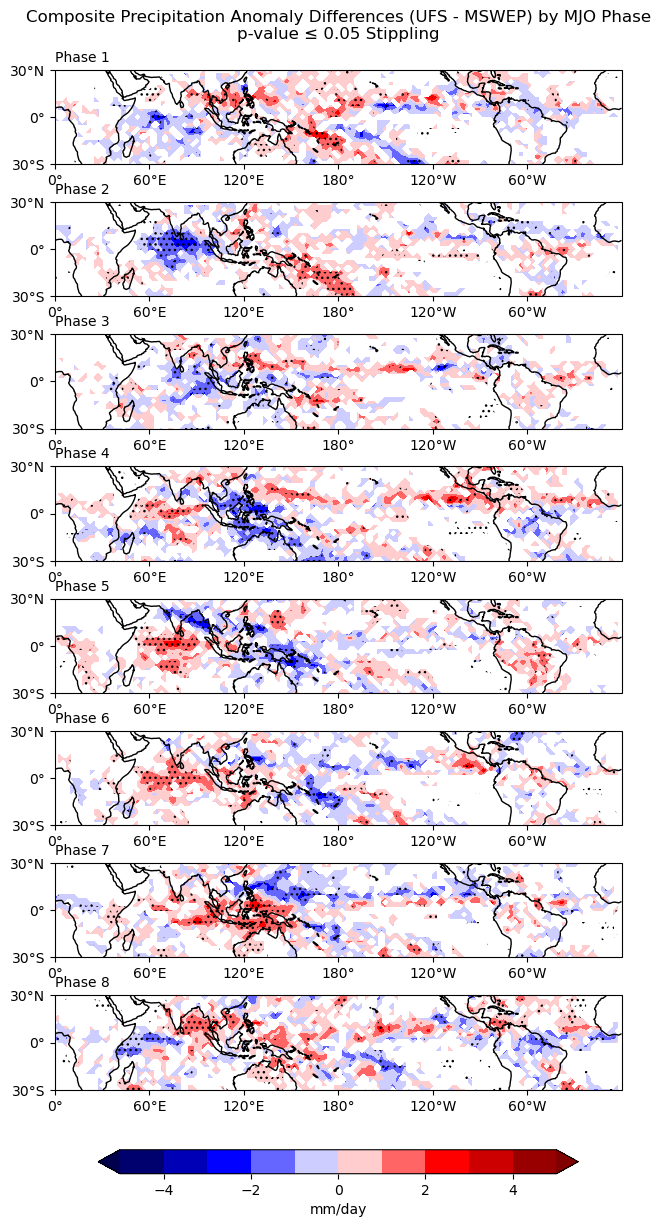

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.mpl.ticker as cticker

# Define contour levels for precipitation anomalies
clevs = np.arange(-5, 6, 1)  # Adjusted for better visualization

# Define the figure and axes for the subplots (one for each MJO phase)
fig, axs = plt.subplots(
    nrows=8, ncols=1,
    figsize=(8, 12),  # Adjusted for better spacing
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)

axs = axs.flatten()  # Flatten axes for easy iteration

# Loop through each phase in the dictionaries

for i, phase in enumerate(diff_composites.keys()):
    # Extract data and mask for the current phase
    data = diff_composites[phase]  # Composite difference
    
    # Get longitude and latitude coordinates
    lons = data['longitude'].values
    lats = data['latitude'].values
    
    
    data = np.ma.masked_where((data >= -0.25) & (data <= 0.25), data) 
    
    mask_data = masked_diffs[phase]  # Masked data 
    
    
    # Set the plot extent to the tropics (MJO region)
    axs[i].set_extent([0, 360, -30, 30], crs=ccrs.PlateCarree())

    # Plot filled contours for data
    cs = axs[i].contourf(
        lons, lats, data,
        levels=clevs, transform=ccrs.PlateCarree(),
        cmap='seismic', extend='both'
    )

    # Overlay stippling for significant regions (p-value ≤ 0.05)
    ss = axs[i].contourf(
        lons, lats, mask_data,
        levels=[0, 1], transform=ccrs.PlateCarree(),
        colors=['none'], hatches=['...'], extend='both'
    )

    # Add coastlines for geographic context
    axs[i].coastlines()

    # Add longitude and latitude gridlines
    axs[i].set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
    axs[i].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axs[i].set_yticks(np.arange(-30, 31, 30), crs=ccrs.PlateCarree())
    axs[i].yaxis.set_major_formatter(cticker.LatitudeFormatter())

    # Add a title for each phase
    axs[i].set_title(f'Phase {phase}', fontsize=10, loc='left')

# Adjust layout for better spacing
fig.subplots_adjust(
    bottom=0.1, top=0.95, left=0.1, right=0.9,
    hspace=0.4
)

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])  # Adjusted position and size
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm/day')

# Add a main title
plt.suptitle(
    'Composite Precipitation Anomaly Differences (UFS - MSWEP) by MJO Phase\np-value ≤ 0.05 Stippling',
    fontsize=12, y = 1
)

# Display the plots
plt.show()